#Implementation of Plestenjak's Planar Graph Drawing Algorithm

In the paper, Plestenjak presents this algorithm to draw planar, 3-connected graphs. It works for other kinds, however, as long as they have at least 1 cycle. The chosen source node for ``` find_cycle()``` would need to be in said cycle, however. Thus, maybe another way for finding a cycle would be better.


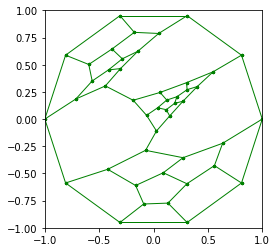

In [ ]:
import math
import random
import numpy as np
import networkx as nx
import networkx.algorithms.cycles as cyc
import matplotlib.pyplot as plt
 
#testing Tutte Graph
G = nx.tutte_graph() #[0, 1, 2, ..., 44, 45]
n = len(G.nodes)
 
#recommended parameters
C = math.sqrt(n / math.pi)
def cool(i):
  return math.sqrt(math.pi / n) / ((1 + (math.pi / n) * i ** (3 / 2)))
 
#actual algorithm, adds the coordinates to each node. We can automate the maxIteration
def PlanarEmbed(G, max, C=C, cool=cool): #default parameters for easy use
    #at the moment, random source and ignore orientation (good)
    source = random.choice(list(G.nodes)) #since this finds longest path, hamiltonian graphs look uninteresting
    outerCycle = list(cyc.find_cycle(G, source=source))
    #get inner and outer node sets
    outerNodes = [e[0] for e in outerCycle]
    innerNodes = [v for v in G.nodes if not v in outerNodes]
 
    #step 1
    q = len(outerNodes)
    for i in range(q): #for outer nodes, unit circle coordinates
        v = outerNodes[i]
        angle = (2 * math.pi * i) / q
        x, y = math.cos(angle), math.sin(angle)
        G.nodes[v]["position"] = np.array([x, y], dtype=float)
 
    for v in innerNodes: #for inner nodes, zero vector coordinate
        G.nodes[v]["position"] = np.zeros(2, dtype=float)
 
    #step 2
    for i in range(max):
        for v in G.nodes: #a: set the force to 0 for all v
            G.nodes[v]["force"] = np.zeros(2, dtype=float)
        
        for e in G.edges: #b: adjust force for inner and outer v
            u = e[0]
            v = e[1]
            posv = G.nodes[v]["position"]
            posu = G.nodes[u]["position"]
            F = C * np.power((posv - posu), 3)
            G.nodes[u]["force"] += F
            G.nodes[v]["force"] -= F
        
        for v in innerNodes: #c: move coordinates for inner v
            F = G.nodes[v]["force"]
            d = np.linalg.norm(F)
            if (d > 0): #avoids div by 0, not all inner are neighbors to outers
                displacement = (min([d, cool(i)]) / d)
                G.nodes[v]["position"] += displacement * F 
 
def PlotGraph(G):
    for e in G.edges:
        u = e[0]
        v = e[1]
        pos1 = G.nodes[u]["position"]
        pos2 = G.nodes[v]["position"]
        x1, x2 = pos1[0], pos2[0]
        y1, y2 = pos1[1], pos2[1]
        plt.plot([x1, x2], [y1, y2], 'go-', markersize=2.3, linewidth=1)
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.draw()
 
PlanarEmbed(G, 256)
PlotGraph(G)

Since the function ```find_cycle()``` finds the longest cycle starting from the source, hamiltonian graphs produce uninteresting embeddings due to **every** vertex being in the outer unit circle. This likely produces a self-intersecting embedding of a planar graph.

For example, the embedding of the dodecahedral graph:

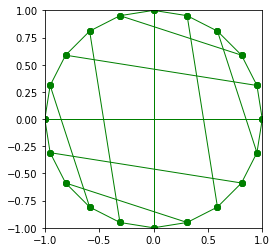

#Implementation of Papamanthou-Tollis Parameterized st-Orientation Generator

This is an implementation of the standard STN, where ```choose()``` is a random sampling

s, t: 3, 1
[3 4 2 0 1]
[4 1 3 1 2]


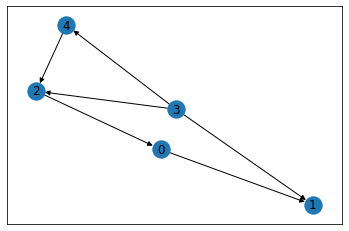

In [77]:
import math
import random
import numpy as np
import networkx as nx
import networkx.algorithms as alg
 
#example tutte graph
G = nx.house_graph()
n = G.number_of_nodes()
s, t = random.sample(list(G.nodes), 2)

def choose(pool):
      vc = random.choice(list(pool)) #change this later
      return vc

def UpdateBlocks(G):
    global t

    T = nx.DiGraph()

    cut_points = list(nx.articulation_points(G))
    blocks = [tuple(x) for x in nx.biconnected_components(G)]

    for b in blocks:
        if t in b:
            root = b

    T.add_node(root)

    block_stack = []
    processed_blocks = []
    processed_nodes = []
    block_stack.append(root)

    while (block_stack):
        r = block_stack.pop()

        processed_blocks.append(r)
        cut_point_children = [cp for cp in r if cp in cut_points and not cp in processed_nodes]

        for cp in cut_point_children:
            T.add_node(cp)
            T.add_edge(r, cp)

            processed_nodes.append(cp)
            block_children = [b for b in blocks if cp in b and not b in processed_blocks]

            for b in block_children:
                T.add_node(b)
                T.add_edge(cp, b)

                block_stack.append(b)

    #nx.draw_networkx(T, arrows=True)
    return T



def STREC(G, v):
    global j, Q, n, t
    #if (not nx.is_biconnected(G)):
    #    return
    #print(f"iteration: {j}")
    j = j+1
    f[v] = j #assuming vertex labels are ints
    
    neighbors = list(G.neighbors(v))

    F.add_node(v)
    [F.add_edge(v, n) for n in neighbors]
    G.remove_node(v)

    Q = Q.union({n for n in neighbors if n != t})
    Q.discard(v)

    for n in neighbors:
        m[n] = j

    if not Q:
        f[t] = n
        return

    else:
        T = UpdateBlocks(G)
        leaf_blocks = [node for node in T.nodes if T.out_degree(node)==0]

        for block in leaf_blocks:
            predecessors = list(T.predecessors(block)) #zero or last?
            #print(f"predecessors: {predecessors}")

            #print(f"Q: {Q}")
            if not predecessors: #no predecessors, G is still biconnected
                choosable = Q.intersection(set(block))
            else:
                p = predecessors[0]
                choosable = Q.intersection(set(block))
                choosable.discard(p)
            #print(f"choosable: {choosable}")

            choice = choose(choosable)

            STREC(G, choice)

def STN(G, s):
    if (not nx.is_biconnected(G)):
        return
    else:
        STREC(G, s)

F = nx.DiGraph()
m = np.zeros(G.number_of_nodes(), dtype=int)
f = np.zeros(G.number_of_nodes(), dtype=int)
j = 0
Q = {s}
STN(G, s)

print(f"s, t: {s}, {t}")
print(m)
print(f)
nx.draw_networkx(F, arrows=True)

testing out the orientation


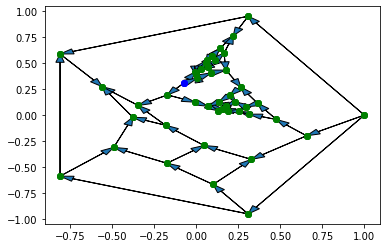

In [ ]:
import matplotlib.pyplot as plt
 
n = len(F.nodes)
 
#recommended parameters
C = math.sqrt(n / math.pi)
def cool(i):
  return math.sqrt(math.pi / n) / ((1 + (math.pi / n) * i ** (3 / 2)))
 
def PlanarEmbed(G, max, C=C, cool=cool): #default parameters for easy use
    #at the moment, random source and ignore orientation (good)
    source = random.choice(list(G.nodes)) #since this finds longest path, hamiltonian graphs look uninteresting
    outerCycle = list(cyc.find_cycle(G, source=source))
    #get inner and outer node sets
    outerNodes = [e[0] for e in outerCycle]
    innerNodes = [v for v in G.nodes if not v in outerNodes]
 
    #step 1
    q = len(outerNodes)
    for i in range(q): #for outer nodes, unit circle coordinates
        v = outerNodes[i]
        angle = (2 * math.pi * i) / q
        x, y = math.cos(angle), math.sin(angle)
        G.nodes[v]["position"] = np.array([x, y], dtype=float)
 
    for v in innerNodes: #for inner nodes, zero vector coordinate
        G.nodes[v]["position"] = np.zeros(2, dtype=float)
 
    #step 2
    for i in range(max):
        for v in G.nodes: #a: set the force to 0 for all v
            G.nodes[v]["force"] = np.zeros(2, dtype=float)
        
        for e in G.edges: #b: adjust force for inner and outer v
            u = e[0]
            v = e[1]
            posv = G.nodes[v]["position"]
            posu = G.nodes[u]["position"]
            F = C * np.power((posv - posu), 3)
            G.nodes[u]["force"] += F
            G.nodes[v]["force"] -= F
        
        for v in innerNodes: #c: move coordinates for inner v
            F = G.nodes[v]["force"]
            d = np.linalg.norm(F)
            if (d > 0): #avoids div by 0, not all inner are neighbors to outers
                displacement = (min([d, cool(i)]) / d)
                G.nodes[v]["position"] += displacement * F 
 
def PlotGraph(G, s, t):
    for e in G.edges:
        u = e[0]
        v = e[1]
        color = "green"
        if (u == s):
            color = "blue"
        elif (v == t):
            color = "red"
        pos1 = G.nodes[u]["position"]
        pos2 = G.nodes[v]["position"]
        x1, x2 = pos1[0], pos2[0]
        y1, y2 = pos1[1], pos2[1]
        plt.plot(x1, y1, "go--", color=color)
        plt.plot(x2, y2, "go--", color=color)
        plt.arrow(x1, y1, x2-x1, y2-y1, 
            length_includes_head=True,
            head_width=0.05, head_length=0.08)
 
PlanarEmbed(F, C, cool, 256, 0.01)
PlotGraph(F, s, t)

References:
 
---
 
B. Plestenjak, 'An Algorithm for Drawing Planar Graphs' https://www.fmf.uni-lj.si/~plestenjak/Papers/schlegel
 
C. Papamanthou, I. G. Tollis, 'Algorithms for computing a parameterized st-orientation' https://www.researchgate.net/publication/220149886_Algorithms_for_computing_a_parameterized_st-orientation